In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import arange
import sympy
from sympy import oo

In [54]:
x_symbol = sympy.Symbol('x')

In [55]:
def create_polynomial(params):
    '''
    Creates a polynomial function with the specified parameters as a sympy function object. Note that params[0] is the y-intercept. The order of the polynomial is given by the length of the parameters vector.
    f(x) = sum from i = 0 to n (theta_i * x^i); where n = len(params) - 1
    :param params: vector of parameters
    :return: sympy function object
    '''
    f = 0
    for i,theta in enumerate(params):
        f += theta * x_symbol**i
    return f

def eval(f, x):
    '''
    Evaluates a sympy function object at the specified x - value.
    :param f: sympy function object
    :param x: x - value
    :return: y - value
    '''
    f_lambdify = sympy.lambdify(x_symbol, f, 'numpy')
    return f_lambdify(x)


In [56]:
def spline_objective_function(x, y, r, lambda_):
    '''
    Mean squared error with added penalty, favors curves with a lower average curvature.
    Mathematical formula:
    L(r, theta) = 1/n * sum from i = 1 to n ((y_i - f(x_i))^2) + theta* integral over all x (dx(r''(x))^2)
     In words: mean squared error + lambda * measure of curvature of m over all x
    Note: The sign of m''(x) indicates whether m(x) is concave/convex, we square it to just measure how curved m is at x.
    :param x: vector of x - values
    :param y: vector of corresponding y - values
    :param r: function of a curve/ spline which attempts to approximate the relationship between x and y
    :param theta: weight of the curvature penalty
    :return:
    '''
    y_hat = eval(r, x)
    m = len(x)
    mse = 1/m * np.sum((y - y_hat)**2)
    drdx = sympy.diff(r, x_symbol)
    drdx2 = sympy.diff(drdx, x_symbol)
    curvature = (drdx2)**2
    # sympy.oo represents infinity
    curvature_integral = sympy.integrate(curvature, (x_symbol, np.min(x), np.max(x)))
    L = mse + lambda_ * curvature_integral

    return L

In [87]:
def ReLu(f):
    '''
    Rectified Linear Unit function on sympy function object f
            / a, if a > 0
    a_+ =  |
           \ 0, otherwise
    :param f: sympy function object
    :return: a+
    '''
    return sympy.Max(f, 0)

In [82]:
def smoothening_spline(x,y):
    '''
    Splines are piecewise cubic polynomials. Following the formula.
    We define a cubic polynomial in between each of the knots (x_j,x_j+1). And one cubic polynomial outside of the knots(-oo to x_0 and x_m to oo).
    r(x) = sum from j = 0 to n = 3 (beta_j * B_j(x))
    where B_j(x) is the jth base function. A common choice is
    B_1(x) = 1
    B_2(x) = x
            / a, if a > 0
    a_+ =  |
           \ 0, otherwise
                (x-x_i)_+^3 - (x-x_m)_+^3       (x-x_(m-1))_+^3 - (x-x_m)_+^3
    B_i+2(x) =  ------------------------- minus ---------------------------
                        x_m - x_i                         x_m - x_(m-1)
    :param x: a vector of x in increasing order, also called the 'knots' of the spline
    :return:
    '''
    # check if x is in increasing order:
    increasing = all(x[i] <= x[i+1] for i in range(len(x)-1))
    if not increasing:
        # sort x in increasing order
        x = np.sort(x)

    m = len(x)
    basis_functions = []
    B_matrix = np.zeros((4,m))
    # this basis function has the property that the second and third derivatives of each Bj are zero outside the interval (x1, xn). Therefore they are indicator functions as to whether each x in the interval (x1, xn) is in the interval (xj, xj+1) or not.
    for i in range(4):
        if i == 0:
            basis_functions.append(x_symbol**0)
        elif i == 1:
            basis_functions.append(x_symbol**1)
        elif i == 2 or i == 3:
            part_1 = (ReLu(x_symbol - x[i-2]) ** 3 - ReLu(x_symbol - x[m-1]) ** 3)/(x[m-1] - x[i-2])
            part_2 = (ReLu(x_symbol - x[m-2]) ** 3 - ReLu(x_symbol - x[m-1]) ** 3)/(x[m-1] - x[m-2])
            B_j = part_1 - part_2
            basis_functions.append(B_j)
        basis_functions.append(x_symbol ** i)
        B_matrix[i] = eval(basis_functions[i],x)
    BTB = np.dot(B_matrix.T,B_matrix)
    BTB_inv = np.linalg.inv(BTB)
    BTB_invBT = np.dot(BTB_inv,B_matrix.T)
    # This performs an Ordinary Least Squares (OLS) with B in place of x:
    # beta_hat = (BT*B)-1 * BT * y
    beta_hat = np.dot(BTB_invBT,y)

    # TODO: continue at formula 15 on page 11 of Lecture 11: Splines
    # TODO: implement spline objective function
    # TODO: implement curvature matrix omega
    # TODO: find smoothening spline by differentiating with respect to beta and setting to zero
    # mathemagic... (write down formula derivation)
    # only implement beta_hat = (this is the optimal beta_hat)
    return B_matrix

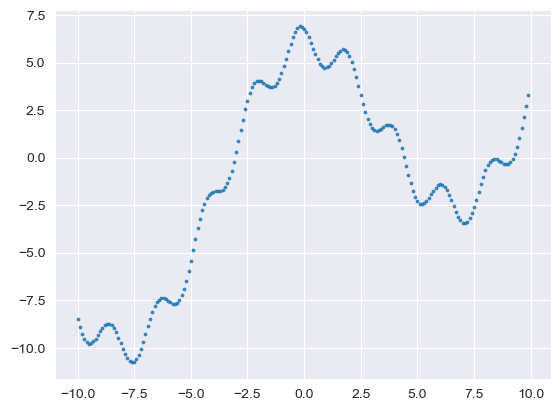

In [73]:
# initialize x as a range of numbers from -10 to 10
x = arange(-10, 10, 0.1)
f =  6 * sympy.cos(3/7*x_symbol+1/9) + sympy.sin(3*x_symbol+2.167) + 1/2 * x_symbol
y = eval(f,x)

# scatterplot
plt.scatter(x, y, alpha=0.8, s=3)
plt.show()

In [58]:
L = spline_objective_function(x,y,m,0.1)
L

2364.35879999997

In [83]:
B=basis_function(x)